# Voxelized Phantom and Radiograph Simulation

Prerequisite: [03_studies.ipynb](03_studies.ipynb)

This notebook demonstrates how to:
1. Download and load a set of DICOM files to create a voxelized phantom.
2. Run a standard CT simulation using `VITools`.
3. Run a custom "Flat Panel" simulation (e.g., for a projected radiograph) using custom configuration files.

In [1]:
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pydicom
import glob
import gecatsim as xc
from VITools.phantom import Phantom
from VITools.scanner import Scanner

## 1. Download and Prepare the Phantom

We will download a series of DICOM files (slices 001 to 102) from the XCIST repository to use as our voxelized phantom.

In [2]:
def download_dicom_series(base_url, output_dir='dicom_input', start_idx=1, end_idx=102):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    files = []
    print(f"Downloading DICOM series to {output_dir}...")
    
    for i in range(start_idx, end_idx + 1):
        filename = f"1-{i:03d}.dcm"
        file_path = os.path.join(output_dir, filename)
        files.append(file_path)
        
        if os.path.exists(file_path):
            continue
            
        # Construct URL
        # The provided example URL structure suggests the file is at the end
        url = f"{base_url}/{filename}"
        raw_url = url.replace('blob', 'raw')
        
        try:
            response = requests.get(raw_url)
            response.raise_for_status()
            with open(file_path, 'wb') as f:
                f.write(response.content)
        except Exception as e:
            print(f"Failed to download {filename}: {e}")
            
    print("Download complete.")
    return files

# Base URL for the DICOM folder
base_dicom_url = "https://github.com/xcist/phantoms-voxelized/blob/main/DICOM_to_voxelized/example_body_DICOMs_Siemens/manifest-1647219545991/CPTAC-PDA/C3N-00249/11-22-2009-NA-CT%20CHEST%20W%20IV%20CONTRAST-80052/2.000000-CHEST%20%203.0%20%20B40f-93926"

dicom_files = download_dicom_series(base_dicom_url, output_dir='phantoms/dicom_series', start_idx=1, end_idx=102)

Download complete.


In [3]:
# Load DICOMs into a numpy array
def load_dicom_volume(file_list):
    # Sort files to ensure correct order
    file_list.sort()
    
    slices = [pydicom.dcmread(f) for f in file_list]
    # Sort by Instance Number or Image Position Patient Z if needed, but filenames usually imply order
    slices.sort(key=lambda x: x.InstanceNumber)
    
    # Extract spacings
    # PixelSpacing is (row_spacing, col_spacing) -> (dy, dx)
    # SliceThickness is dz
    ds = slices[0]
    dy, dx = ds.PixelSpacing
    dz = ds.SliceThickness
    spacings = (float(dz), float(dy), float(dx))
    
    # Stack pixel arrays
    # Convert to HU: pixel_array * RescaleSlope + RescaleIntercept
    volume = np.stack([s.pixel_array * s.RescaleSlope + s.RescaleIntercept for s in slices])
    
    return volume.astype(np.float32), spacings

print("Loading DICOM volume...")
phantom_data, voxel_spacing = load_dicom_volume(dicom_files)
print(f"Volume shape: {phantom_data.shape}")
print(f"Voxel spacing (z, y, x): {voxel_spacing}")

# Create the VITools Phantom object
phantom = Phantom(phantom_data, spacings=voxel_spacing, patient_name='CPTAC-PDA', patientid=249)
print(phantom)

Loading DICOM volume...
Volume shape: (102, 512, 512)
Voxel spacing (z, y, x): (3.0, 0.8828125, 0.8828125)

        Phantom Class: Phantom
        Age (years): 0
        Shape (voxels): (102, 512, 512)
        Size (mm): (306.0, 452.0, 452.0)
        


## 2. Standard CT Simulation

First, we initialize a default scanner and run a standard helical or axial CT scan.

Initializing Scanner object...
----------
* Calculating volume fraction maps for 4 materials and 102 slices...
* Writing volume fraction files for 4 materials and 102 slices, plus HU data...
* Writing output_ct/CPTAC-PDA/phantoms/249/249_ncat_adipose_512x512x102.raw...
* Writing output_ct/CPTAC-PDA/phantoms/249/249_ncat_water_512x512x102.raw...
* Writing output_ct/CPTAC-PDA/phantoms/249/249_ncat_brain_512x512x102.raw...
* Writing output_ct/CPTAC-PDA/phantoms/249/249_ncat_skull_512x512x102.raw...
* Writing output_ct/CPTAC-PDA/phantoms/249/249_HU_data_512x512x102.raw...
* Writing output_ct/CPTAC-PDA/phantoms/249/249.json...
Scanner Ready


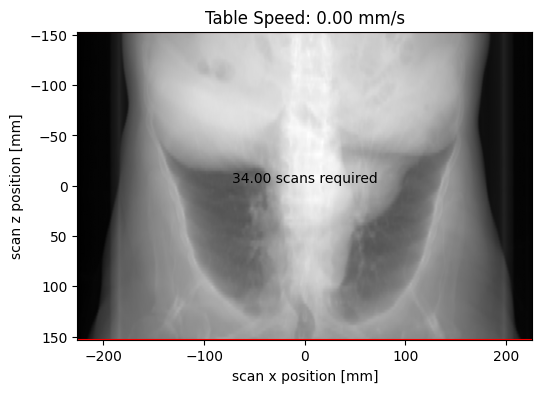

In [4]:
# Initialize Scanner
scanner_ct = Scanner(phantom, scanner_model="Scanner_Default", output_dir="output_ct")

# Visualize the setup (Scout View)
plt.figure(figsize=(10, 4))
scanner_ct.scout_view()
plt.show()

In [5]:
# Run Scan and Reconstruction
# We'll scan a smaller range to save time for this example, e.g., 50mm centered.
center_z = 0
scan_range = 20
start_z = center_z - scan_range / 2
end_z = center_z + scan_range / 2

print("Running CT Scan...")
scanner_ct.run_scan(mA=50, kVp=120, startZ=start_z, endZ=end_z, pitch=1.0)

Running CT Scan...
Airscan
Offset scan
Phantom scan


  0%|          | 0/3000 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated a total of    408 MB.


100%|██████████| 3000/3000 [1:02:08<00:00,  1.24s/it]


Prep view
Applying LSC...done.

Applying Beam Hardening Correction (ACCURATE BHC)...Airscan
done.

Simulation is done.



        Scanner default_series
        Scanner: Scanner_Default
        Simulation Platform: CATSIM
        

Running Reconstruction...
fov size: 400
* Loading the projection data...
* Rebinning the projection...
* Applying the filter...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
   recon slice 0/6...
   recon slice 1/6...
   recon slice 2/6...
   recon slice 3/6...
   recon slice 4/6...
   recon slice 5/6...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...


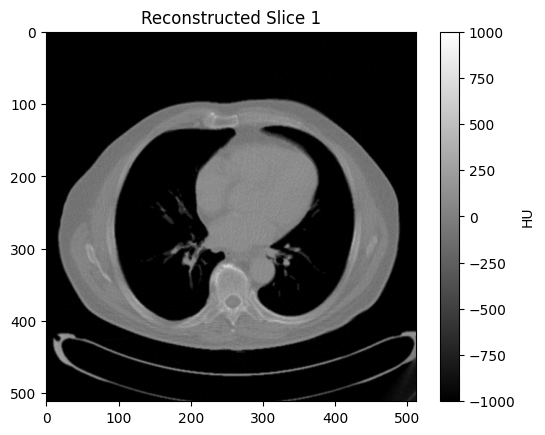

DICOM saved to output_ct/dicom


/home/sarah/Dev/VITools/.vitools/lib/python3.10/site-packages/pydicom/valuerep.py:440: UserWarning: Invalid value for VR UI: '1.3.6.1.4.1.5962.1.3.1.1.20040119072730.00'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)
/home/sarah/Dev/VITools/.vitools/lib/python3.10/site-packages/pydicom/valuerep.py:440: UserWarning: Invalid value for VR UI: '1.3.6.1.4.1.5962.1.1.1.1.1.20040119072730.000'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)
/home/sarah/Dev/VITools/.vitools/lib/python3.10/site-packages/pydicom/valuerep.py:440: UserWarning: Invalid value for VR UI: '1.3.6.1.4.1.5962.1.1.1.1.1.20040119072730.001'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)


In [6]:
print("Running Reconstruction...")
# Note: The provided phantom has a slice thickness of 3.0mm. We reconstruct with similar thickness.
scanner_ct.run_recon(fov=400, slice_thickness=3.0)

# Visualize a reconstructed slice
if scanner_ct.recon is not None and len(scanner_ct.recon) > 0:
    mid_slice = scanner_ct.recon.shape[0] // 2
    plt.imshow(scanner_ct.recon[mid_slice], cmap='gray', vmin=-1000, vmax=1000)
    plt.title(f"Reconstructed Slice {mid_slice}")
    plt.colorbar(label='HU')
    plt.show()

# Save DICOM
dicom_path = Path("output_ct") / "dicom" / "ct_scan.dcm"
scanner_ct.write_to_dicom(dicom_path)
print(f"DICOM saved to {dicom_path.parent}")

## 3. Flat Panel / Radiograph Simulation

Now we demonstrate a custom use case using specific configuration files for a Flat Panel detector. This could be used to simulate a single projected radiograph or a specific acquisition protocol.

In [7]:
# Create the configuration files directory
cfg_dir = Path('cfg')
cfg_dir.mkdir(exist_ok=True)

# Define config content
protocol_cfg = """
protocol.scanTypes = [1, 1, 1]              # flags for airscan, offset scan, phantom scan 
 
# Table and gantry 
protocol.scanTrajectory = "Gantry_Helical"	# name of the function that defines the scanning trajectory and model 
protocol.viewsPerRotation = 10	    	    # total numbers of view per rotation 
protocol.viewCount = 10                    # total number of views in scan 
protocol.startViewId = 0		            # index of the first view in the scan 
protocol.stopViewId = protocol.startViewId+protocol.viewCount-1 # index of the last view in the scan 
protocol.airViewCount = 1		            # number of views averaged for air scan 
protocol.offsetViewCount = 1		        # number of views averaged for offset scan 
protocol.rotationTime = 1.0		            # gantry rotation period (in seconds) 
protocol.rotationDirection = 1		        # gantry rotation direction (1=CW, -1 CCW, seen from table foot-end) 
protocol.startAngle = 0		                # relative to vertical y-axis (n degrees) 
protocol.tableSpeed = 0		                # speed of table translation along positive z-axis (in mm/sec) 
protocol.startZ = 0		                    # start z-position of table 
protocol.tiltAngle = 0		                # gantry tilt angle towards negative z-axis (in degrees) 
protocol.wobbleDistance = 0.0		        # focalspot wobble distance 
protocol.focalspotOffset = [0, 0, 0]		# focalspot position offset 
 
# X-ray tube technique and filtration 
protocol.mA = 20		                    # tube current (in mA) 
protocol.spectrumCallback = "Spectrum"		# name of function that reads and models the X-ray spectrum 
protocol.spectrumFilename = "tungsten_tar7.0_120_filt.dat" # name of the spectrum file 
protocol.spectrumScaling = 1		        # scaling factor such that spectrum is in photons / mA / s / mm^2 at 1000 mm 
protocol.bowtie = ""       # name of the bowtie file (or []) 
protocol.filterCallback = "Xray_Filter"     # name of function to compute additional filtration 
protocol.flatFilter = ['al',3.0]            # additional filtration - materials and thicknesses (in mm) 
protocol.dutyRatio = 1.0                    # tube ON time fraction (for pulsed tubes) 
"""

physics_cfg = """
# Geometric and energy sampling 
physics.energyCount = 20 
physics.monochromatic = -1 
physics.colSampleCount = 1 
physics.rowSampleCount = 1 
physics.srcXSampleCount = 1 
physics.srcYSampleCount = 1 
physics.viewSampleCount = 1 
 
# Pre-image sampling and ways to model detector aliasing for flat-panel detector 
physics.FlatPanel_OSfactor = 1 # from 3, when  > 1 seems to break prepview 
physics.DetectorAliasMode = 1 
 
# Flags to determine what has to be recalculated each view 
physics.recalcDet = 0 
physics.recalcSrc = 0 
physics.recalcRayAngle = 0 
physics.recalcSpec = 0 
physics.recalcFilt = 0 
physics.recalcFlux = 0 
physics.recalcPht = 0 
physics.recalcDet = 0 
 
# Noise on/off settings 
physics.enableQuantumNoise = 0 
physics.enableElectronicNoise = 0 
 
# Internal physics models 
physics.rayAngleCallback = "Detector_RayAngles_2D" 
physics.fluxCallback = "Detection_Flux" 
physics.scatterCallback = "" 
physics.prefilterCallback = "Detection_prefilter" 
physics.crosstalkCallback = "" 
physics.lagCallback = "" 
physics.opticalCrosstalkCallback = "Detection_OpticalCrosstalk_FlatPanel" 
physics.DASCallback = "Detection_DAS_FlatPanel" 
 
# I/O preferences 
physics.outputCallback = "WriteRawView" 
"""

scanner_cfg = """
# Scanner geometry 
scanner.detectorCallback = "Detector_FlatPanel" # name of function that defines the detector shape and model 
scanner.sid = 900.0                         # source-to-iso distance (in mm) 
scanner.sdd = 950.0                         # source-to-detector distance (in mm) 
scanner.detectorColCount = 500             # total number of detector columns 
scanner.detectorRowCount = 500             # total number of detector rows 
scanner.detectorColOffset = 0.0             # detector column offset relative to centered position (in detector columns) 
scanner.detectorRowOffset = 0.0             # detector row offset relative to centered position (in detector rows) 
scanner.detectorColSize = 0.5               # detector column pitch or size (in mm) 
scanner.detectorRowSize = 0.5               # detector row pitch or size (in mm) 
scanner.detectorPrefilter = ['graphite', 1.0]  # detector filter 
 
# X-ray tube 
scanner.focalspotCallback = "SetFocalspot"  # name of function that defines the focal spot shape and model 
scanner.focalspotShape = "Uniform"          # Parameterize the model 
scanner.targetAngle = 7.0                   # target angle relative to scanner XY-plane (in degrees) 
scanner.focalspotWidth = 1.0 
scanner.focalspotLength = 1.0 
 
# Detector 
scanner.detectorMaterial = "lumex"          # detector sensor material 
scanner.detectorDepth = 3.0                 # detector sensor depth (in mm) 
scanner.detectionCallback = "Detection_EI"  # name of function that defines the detection process (conversion from X-rays to detector signal) 
scanner.detectionGain = 15.0                # factor to convert energy to electrons (electrons / keV) 
scanner.FlatPanel_H = 0.2026                # Parameter controlling the spread of OTF (flat-panel detector) 
scanner.detectorColFillFraction = 0.8       # active fraction of each detector cell in the column direction 
scanner.detectorRowFillFraction = 0.8       # active fraction of each detector cell in the row direction 
scanner.eNoise = 0.0                     # standard deviation of Gaussian electronic noise (in electrons)
"""

# Write configs to file
with open(cfg_dir / 'protocol_flat_panel.cfg', 'w') as f:
    f.write(protocol_cfg)
with open(cfg_dir / 'physics_flat_panel.cfg', 'w') as f:
    f.write(physics_cfg)
with open(cfg_dir / 'scanner_flat_panel.cfg', 'w') as f:
    f.write(scanner_cfg)
    
print("Config files created in cfg/")

Config files created in cfg/


In [8]:
# Initialize a new scanner object for the flat panel simulation
scanner_fp = Scanner(phantom, output_dir="output_flat_panel")

# Load the custom configurations
print("Loading custom configuration...")
scanner_fp.xcist.load_cfg(
    cfg_dir / 'protocol_flat_panel.cfg', 
    cfg_dir / 'physics_flat_panel.cfg', 
    cfg_dir / 'scanner_flat_panel.cfg'
)

# Run the simulation
print("Running Flat Panel Simulation...")
scanner_fp.run_scan(views=1, bhc=False)

Initializing Scanner object...
----------
* Calculating volume fraction maps for 4 materials and 102 slices...
* Writing volume fraction files for 4 materials and 102 slices, plus HU data...
* Writing output_flat_panel/CPTAC-PDA/phantoms/249/249_ncat_adipose_512x512x102.raw...
* Writing output_flat_panel/CPTAC-PDA/phantoms/249/249_ncat_water_512x512x102.raw...
* Writing output_flat_panel/CPTAC-PDA/phantoms/249/249_ncat_brain_512x512x102.raw...
* Writing output_flat_panel/CPTAC-PDA/phantoms/249/249_ncat_skull_512x512x102.raw...
* Writing output_flat_panel/CPTAC-PDA/phantoms/249/249_HU_data_512x512x102.raw...
* Writing output_flat_panel/CPTAC-PDA/phantoms/249/249.json...
Scanner Ready
Loading custom configuration...
Running Flat Panel Simulation...
scan: 1/2
Airscan
Offset scan
Phantom scan


  0%|          | 0/1 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated a total of    408 MB.


100%|██████████| 1/1 [00:20<00:00, 20.36s/it]


Prep view
Applying LSC...done.

Simulation is done.
scan: 2/2
Airscan
Offset scan
Phantom scan


  0%|          | 0/1 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated a total of    408 MB.


100%|██████████| 1/1 [00:20<00:00, 20.96s/it]

Prep view
Applying LSC...done.

Simulation is done.



        Scanner default_series
        Scanner: Scanner_Default
        Simulation Platform: CATSIM
        

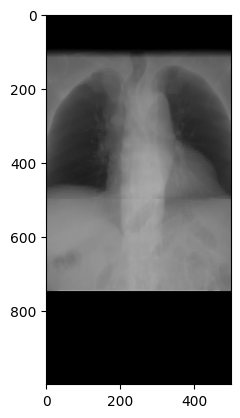

In [9]:
from VITools.scanner import get_projection_data
projections = []
for proj in scanner_fp._projections:
    scanner_fp.xcist.cfg.resultsName = proj
    scanner_fp.xcist.resultsName = scanner_fp.xcist.cfg.resultsName
    projections.append(get_projection_data(scanner_fp.xcist))
projections = np.concatenate(projections[::-1], axis=1)
plt.imshow(projections[0], cmap='grey')

(np.float64(-0.5), np.float64(499.5), np.float64(999.5), np.float64(-0.5))

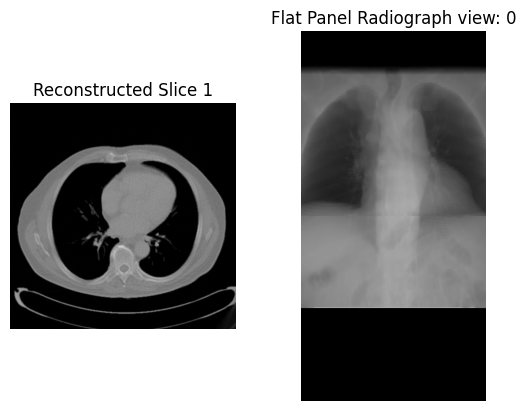

In [10]:
radiograph_view = 0
f, axs = plt.subplots(1,2)
axs[0].imshow(scanner_ct.recon[mid_slice], cmap='gray', vmin=-1000, vmax=1000)
axs[0].set_title(f"Reconstructed Slice {mid_slice}")
axs[0].axis('off')
axs[1].imshow(projections[0], cmap='grey')
axs[1].set_title(f"Flat Panel Radiograph view: {radiograph_view}")
axs[1].axis('off')